In [57]:
#importing libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import sqrt
import seaborn as sns

import sklearn.utils
from sklearn.preprocessing import RobustScaler #Scaling the features
from sklearn.model_selection import StratifiedShuffleSplit #Splitting the dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, auc
from sklearn.model_selection import GridSearchCV #hyperparameter tuning
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier

#Visual Analysis
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import IPython

from imblearn.over_sampling import ADASYN #Adaptive Synthetic Oversampling
from collections import Counter
from scipy import stats


import warnings
warnings.filterwarnings('ignore')

print('Imported successfully')


Imported successfully


In [58]:
# from google.colab import drive
# drive.mount('/content/drive')

In [88]:
df_train = pd.read_csv("./train_jtn_av.csv")
df_test = pd.read_csv("./test_jtn_av.csv")

In [89]:
df_train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [90]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df_train, title="Pandas Profiling Report", explorative=True)
profile.to_file("your_report.html")

In [61]:
df_train.fillna('unknown', inplace=True)
df_test.fillna('unknown', inplace=True)
print(df_train['Credit_Product'].value_counts(dropna=False))
print(df_test['Credit_Product'].value_counts(dropna=False))

No         144357
Yes         72043
unknown     29325
Name: Credit_Product, dtype: int64
No         61608
Yes        31182
unknown    12522
Name: Credit_Product, dtype: int64


In [28]:
# FOR AMT_INCOME_TOTAL COLUMN
q_hi = df_train['Avg_Account_Balance'].quantile(0.999)
q_low = df_train['Avg_Account_Balance'].quantile(0.001)
df_train= df_train[(df_train['Avg_Account_Balance']>q_low) & (df_train['Avg_Account_Balance']<q_hi)]

In [62]:
def bin_ages(age):
     if age <= 30:
        return 'young'
     elif age > 30 and age <= 43:
        return 'middleage'
     elif age>43 and age <= 54:
        return 'aged'
     else:
        return 'old'
    
    
df_train['age_category'] = df_train.apply(lambda x:bin_ages(x.Age),axis=1)
df_test['age_category'] = df_test.apply(lambda x:bin_ages(x.Age),axis=1)

In [63]:
del df_train['ID']
# del df_train['index']
del df_test['ID']
# del young_df
# del middleage_df
# del aged_df
# del old_df


In [64]:
cat_col = ['Gender','Region_Code','Occupation','Channel_Code','Vintage','Credit_Product','Is_Active','age_category']
# cat_col = ['age_category']
from sklearn.preprocessing import LabelEncoder
def label_encoding_col_train_test(df,df_t,cat_col):
    lb = LabelEncoder()
    for col in cat_col:
      df[col] = lb.fit_transform(df[col])
      df_t[col] = lb.transform(df_t[col])  
    return df,df_t

df_train_enc,df_test_enc  = label_encoding_col_train_test(df_train,df_test,cat_col)

In [65]:
df_train.head(20)

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,age_category
0,0,73,18,1,2,18,0,1045696,0,0,2
1,0,30,27,2,0,13,0,581988,0,0,3
2,0,56,18,3,2,10,0,1484315,1,0,2
3,1,34,20,2,0,6,0,470454,0,0,1
4,0,30,32,2,0,14,0,886787,0,0,3
5,1,56,11,3,0,13,0,544163,1,0,2
6,1,62,32,1,2,7,2,1056750,1,1,2
7,0,48,15,3,2,3,0,444724,1,0,0
8,0,40,33,3,1,16,0,1274284,0,0,1
9,0,55,18,3,1,21,1,2014239,0,0,2


In [67]:
# Independent Variables

X = df_train.drop('Is_Lead',1) # selects all columns except "Is_Lead"
# Dependent Variable
y = df_train['Is_Lead']  # 6 is the index of "Is_Lead" in the Training Set 


In [68]:
X

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,age_category
0,0,73,18,1,2,18,0,1045696,0,2
1,0,30,27,2,0,13,0,581988,0,3
2,0,56,18,3,2,10,0,1484315,1,2
3,1,34,20,2,0,6,0,470454,0,1
4,0,30,32,2,0,14,0,886787,0,3
...,...,...,...,...,...,...,...,...,...,...
245720,1,51,34,3,2,51,2,1925586,0,0
245721,1,27,18,2,0,5,0,862952,1,3
245722,0,26,31,2,0,3,0,670659,0,3
245723,0,28,23,2,0,12,0,407504,0,3


In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=df_train.Is_Lead, random_state=1)
# we create the test train split first

In [70]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)
test_df = pd.DataFrame(ss.transform(df_test), columns=df_test.columns)

In [71]:
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# X_balanced, y_balanced = oversample.fit_resample(X_scaled, y_train)
# X_test_balanced, y_test_balanced = oversample.fit_resample(X_test_scaled, y_test)
# we have addressed the issue of oversampling here

### Model training

In [72]:
#Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
sns.set_style("whitegrid")



In [73]:
train_data=lgb.Dataset(X_scaled, label=y_train)

In [74]:
#Initialize Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.001,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error',
          'feature_fraction' : 0.7
          
          }

# Parameters to search
gridParams = {
    'learning_rate': [0.001, 0.01,0.07],
    'n_estimators': [8,16,32],
    'num_leaves': [20, 24, 36],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], 
    'colsample_bytree' : [0.64, 0.65],
    'subsample' : [0.7,0.75],
    }

# Model classifier to use
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])


mdl.get_params().keys()

grid = GridSearchCV(mdl, gridParams, verbose=2, cv=4, n_jobs=-1)

grid.fit(X_scaled, y_train)

print(grid.best_params_)
print(grid.best_score_)



Fitting 4 folds for each of 108 candidates, totalling 432 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.07, 'n_estimators': 32, 'num_leaves': 36, 'objective': 'binary', 'random_state': 501, 'subsample': 0.7}
0.859010996961366


In [94]:
#best_params
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
params['num_leaves'] = grid.best_params_['num_leaves']
params['subsample'] = grid.best_params_['subsample']

print('Params: ')
print(params)

lgbm = lgb.train(params,
                 train_data,
                 200,
                 verbose_eval= 4
                 )

#Predict on test set
predictions_lgbm_prob = lgbm.predict(X_test_scaled)
predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

Params: 
{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'nthread': 5, 'num_leaves': 36, 'learning_rate': 0.07, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.65, 'reg_alpha': 1.2, 'reg_lambda': 1.2, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error', 'feature_fraction': 0.7}
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.65 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.65 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.65 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Number of positive: 52459, number of negative: 168693
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002354 seconds.
You can set 

Overall accuracy of Light GBM model: 0.8622064867944492


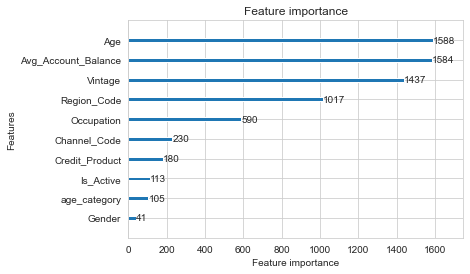

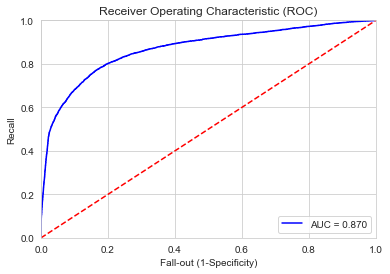

AUC score: 0.869773618917349


<Figure size 432x288 with 0 Axes>

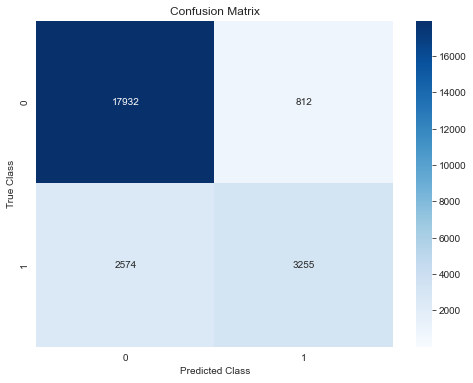

In [95]:
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=10, importance_type='split')

#Print accuracy
acc_lgbm = accuracy_score(y_test,predictions_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)

#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions_lgbm_prob)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(y_test, predictions_lgbm_01)
labels = ['0', '1']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()




In [80]:
predictions_lgbm_prob = lgbm.predict(test_df)
predictions_lgbm_prob

array([0.04267675, 0.8353152 , 0.054873  , ..., 0.06770667, 0.24771021,
       0.05093865])

In [81]:
df_test_pred = pd.read_csv("./test_jtn_av.csv")
df_test_id=df_test_pred['ID']
df_sub = pd.DataFrame({'ID': df_test_id,'Is_Lead':predictions_lgbm_prob})
df_sub.to_csv('exp_submit_lightgbm_hyperparametr_tuning_features.csv') #.8727